### Initialize the environment

In [ ]:
import theano
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
src_dir='../src' # source directory
run_dir='../MDBN_run' # directory with the results of previous runs
data_dir='../data' # directory with the data files

In [11]:
import sys
sys.path.insert(0, src_dir)
import MDBN
import AMLsm2

### Load the experiment results

In [32]:
date_time='2016-12-30_1830' # specify the date and time of the run in the format YYYY-MM-DD_HHMM

runfile='Run_'+date_time+'/Exp_'+date_time+'_run_0.npz' # location of the experiment results
me_DBN, ge_DBN, sm_DBN, dm_DBN, top_DBN = AMLsm2.load_network(runfile,run_dir)

Adding a layer with 559 input and 40 outputs
Adding a layer with 19937 input and 400 outputs
Adding a layer with 400 input and 40 outputs
Adding a layer with 1686 input and 200 outputs
Adding a layer with 200 input and 20 outputs
Adding a layer with 100 input and 24 outputs
Adding a layer with 24 input and 3 outputs


### Visualize the results graphically

In [13]:
datafiles = AMLsm2.prepare_AML_TCGA_datafiles(data_dir)

In [14]:
ME_output, _ = me_DBN.MLP_output_from_datafile(datafiles['ME'], datadir=data_dir)
GE_output, _ = ge_DBN.MLP_output_from_datafile(datafiles['GE'], datadir=data_dir)
SM_output, _ = sm_DBN.MLP_output_from_datafile(datafiles['SM'], datadir=data_dir)

(-0.5, 99.5, 169.5, -0.5)

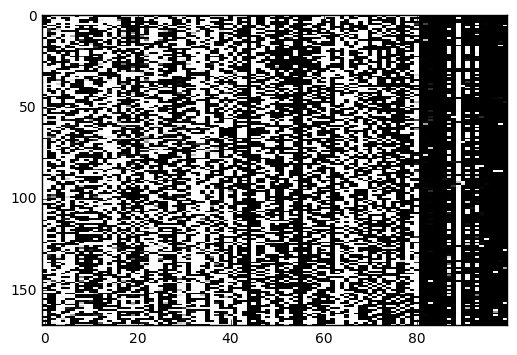

In [17]:
joint_layer = np.concatenate([ME_output, GE_output, SM_output],axis=1)
plt.imshow(joint_layer, cmap='gray',interpolation='none')
plt.axis('tight')

([<matplotlib.axis.XTick at 0x12591ddd0>,
 <a list of 3 Text xticklabel objects>)

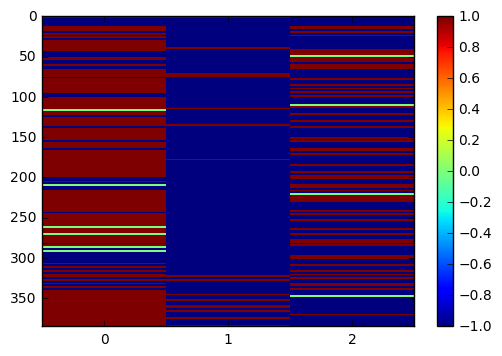

In [18]:
top_output = top_DBN.get_output(theano.shared(joint_layer,borrow=True))
plt.imshow((top_output>0.8)*np.ones_like(top_output)-(top_output<0.2)*np.ones_like(top_output),interpolation='none',extent=[0,3,385,0])
plt.colorbar()
plt.axis('tight')
plt.xticks(np.arange(0.5,3.5,1),('0','1','2'))

([<matplotlib.axis.XTick at 0x11a0b3cd0>,
 <a list of 3 Text xticklabel objects>)

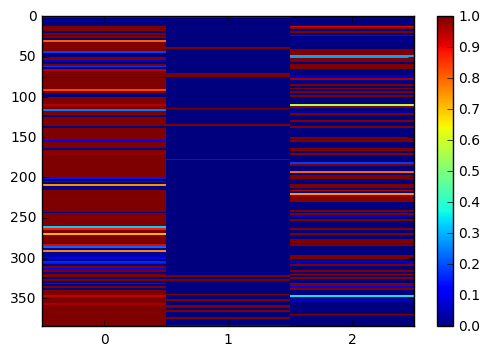

In [19]:
plt.imshow(top_output, interpolation='none',extent=[0,3,385,0])
plt.axis('tight')
plt.colorbar()
plt.xticks(np.arange(0.5,3.5,1),('0','1','2'))

([array([  35.,    7.,    2.,    1.,    0.,    0.,    0.,    3.,    3.,  119.]),
  array([ 154.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,   16.]),
  array([ 108.,    2.,    1.,    1.,    0.,    1.,    0.,    1.,    2.,   54.])],
 array([  3.06261703e-16,   1.00000000e-01,   2.00000000e-01,
          3.00000000e-01,   4.00000000e-01,   5.00000000e-01,
          6.00000000e-01,   7.00000000e-01,   8.00000000e-01,
          9.00000000e-01,   1.00000000e+00]),
 <a list of 3 Lists of Patches objects>)

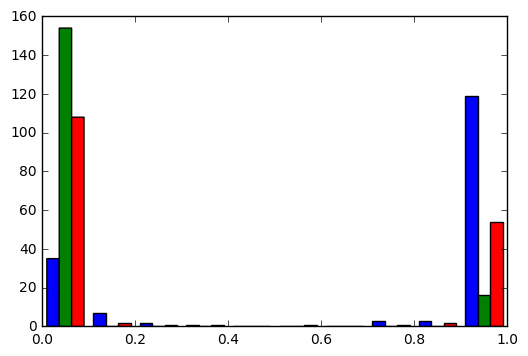

In [20]:
plt.hist(top_output)

In [21]:
code = (top_output[:,0:3] > 0.5) * np.ones_like(top_output[:,0:3])

In [22]:
from utils import find_unique_classes
U = find_unique_classes(code)
cl = U[0]

In [23]:
cl

array([ 4.,  0.,  0.,  0.,  0.,  3.,  3.,  2.,  1.,  2.,  1.,  2.,  0.,
        2.,  2.,  2.,  2.,  4.,  3.,  1.,  1.,  0.,  3.,  3.,  1.,  0.,
        3.,  1.,  1.,  2.,  2.,  4.,  4.,  0.,  3.,  2.,  2.,  3.,  2.,
        3.,  2.,  3.,  0.,  1.,  2.,  2.,  2.,  2.,  3.,  3.,  4.,  0.,
        2.,  3.,  0.,  2.,  2.,  3.,  2.,  4.,  1.,  2.,  2.,  2.,  2.,
        2.,  3.,  2.,  1.,  2.,  2.,  2.,  1.,  3.,  2.,  3.,  2.,  2.,
        4.,  2.,  2.,  3.,  2.,  2.,  2.,  3.,  2.,  3.,  1.,  0.,  2.,
        0.,  3.,  1.,  0.,  3.,  2.,  3.,  3.,  3.,  3.,  3.,  2.,  2.,
        2.,  2.,  3.,  0.,  3.,  2.,  2.,  3.,  2.,  2.,  2.,  0.,  3.,
        2.,  2.,  3.,  2.,  2.,  3.,  3.,  0.,  3.,  0.,  0.,  2.,  0.,
        0.,  1.,  1.,  0.,  0.,  2.,  1.,  2.,  0.,  3.,  0.,  3.,  4.,
        1.,  4.,  0.,  3.,  1.,  2.,  1.,  2.,  2.,  4.,  2.,  2.,  4.,
        2.,  2.,  4.,  4.,  2.,  4.,  2.,  3.,  2.,  4.,  2.,  2.,  2.,  4.])

(array([ 26.,  19.,  70.,  39.,  16.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5]),
 <a list of 5 Patch objects>)

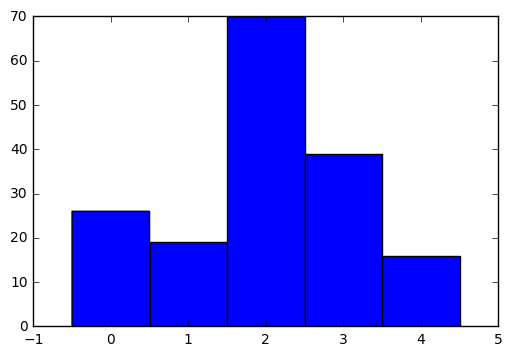

In [30]:
max_cl = np.max(cl)
plt.hist(cl,bins=np.arange(-0.5,max_cl + 1.5,1))

Check Survival curves for the different classes
===============================================

In [34]:
import csv
id=[]
with open('../data/'+datafiles['ME']) as f:
    my_csv = csv.reader(f,delimiter='\t')
    id = my_csv.next()

In [35]:
stat={}
with open('../data/AML/AML_clinical_data2.csv') as f:
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        patient_id=row[0]
        stat[patient_id]=(row[4],row[7],row[6])

In [36]:
import re
time_list = []
event_list = []
group_list = []
print('The following case IDs were  not found in clinical data')
for index, key in enumerate(id[1:]):
    m = re.match('TCGA-\w+-\d+', key)
    patient_id = m.group(0)
    if patient_id in stat:
        patient_stat = stat[patient_id]
        add_group = True
        try:
            time_list.append(float(patient_stat[2]))
            event_list.append(1)
        except ValueError:
            try:
                time_list.append(float(patient_stat[1]))
                event_list.append(0)
            except ValueError:
                print('No data for %s' % patient_id)
                add_group = False
        if add_group:
            group_list.append(cl[index])
    else:
        print(patient_id)

The following case IDs were  not found in clinical data
No data for TCGA-AB-2887
No data for TCGA-AB-2891
No data for TCGA-AB-2918
No data for TCGA-AB-2921
No data for TCGA-AB-2930
No data for TCGA-AB-2940
No data for TCGA-AB-2943
No data for TCGA-AB-2946
No data for TCGA-AB-2975


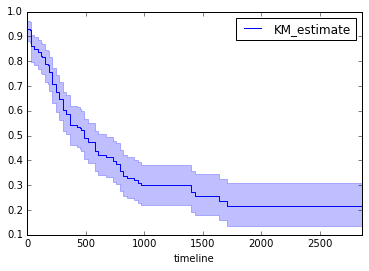

In [37]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(time_list,event_observed=event_list)
kmf.plot()

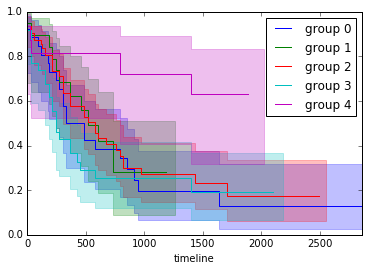

In [43]:
T=np.array(time_list)
E=np.array(event_list)
ix = (np.array(group_list) == 0)
kmf.fit(T[ix], E[ix], label='group 0')
ax=kmf.plot()
for i in range(1,5):
    ix=(np.array(group_list)==i)
    kmf.fit(T[ix], E[ix], label='group %d' % i)
    kmf.plot(ax=ax)